In [38]:
import os
import torch
import warnings
warnings.filterwarnings("ignore")

# Segmentation Models PyTorch Factory

You can use the `SMPModelFactory` to initialize segmentation tasks in TerraTorch. Note that not all models support more than 3 channels (e.g., MiT models).

In [51]:
from segmentation_models_pytorch.encoders import encoders as smp_encoders
print(f'Available SMP backbones: \n{", ".join(smp_encoders)}')

Available SMP backbones: 
resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x4d, resnext101_32x8d, resnext101_32x16d, resnext101_32x32d, resnext101_32x48d, dpn68, dpn68b, dpn92, dpn98, dpn107, dpn131, vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn, senet154, se_resnet50, se_resnet101, se_resnet152, se_resnext50_32x4d, se_resnext101_32x4d, densenet121, densenet169, densenet201, densenet161, inceptionresnetv2, inceptionv4, efficientnet-b0, efficientnet-b1, efficientnet-b2, efficientnet-b3, efficientnet-b4, efficientnet-b5, efficientnet-b6, efficientnet-b7, mobilenet_v2, xception, timm-efficientnet-b0, timm-efficientnet-b1, timm-efficientnet-b2, timm-efficientnet-b3, timm-efficientnet-b4, timm-efficientnet-b5, timm-efficientnet-b6, timm-efficientnet-b7, timm-efficientnet-b8, timm-efficientnet-l2, timm-tf_efficientnet_lite0, timm-tf_efficientnet_lite1, timm-tf_efficientnet_lite2, timm-tf_efficientnet_lite3, timm-tf_efficientnet_lite4, tim

In [53]:
from terratorch.datasets import HLSBands
from terratorch.models import SMPModelFactory

# We use the 6 bands from the HLS Brun Scars dataset.
hls_bands = [
    HLSBands.BLUE,
    HLSBands.GREEN,
    HLSBands.RED,
    HLSBands.NIR_NARROW,
    HLSBands.SWIR_1,
    HLSBands.SWIR_2,
]

# Let's build a segmentation model using segmentation models pytorch
model = SMPModelFactory().build_model(
    task="segmentation",
    backbone="resnet50", # see smp_encoders.keys()
    model='Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus' 
    bands=hls_bands,
    in_channels=6,
    num_classes=2,
    pretrained=True,
)

# Not all models support more than 3 channels (e.g., MiT models).

In [30]:
# Running a test with the model 

trial_data = torch.zeros(2, 6, 224, 224) # batch_size, channels, height, width
output = model(trial_data)
print(f"Features has shape {output.output.shape}")

Features has shape torch.Size([2, 2, 224, 224])


# Datamodule
You can create datamodules for training by leveraging one of our generic data modules. Alternatively, creating your own subclasses of `torchgeo.datamodules.GeoDataModule` or `torchgeo.datamodules.NonGeoDataModule`.

Datamodules package train, test and validation datasets as well as any transforms done.

Any [TorchGeo](https://torchgeo.readthedocs.io/en/stable/) datamodule will also be compatible with TerraTorch.

## Example

Let's use the burn scar segmentation dataset as an example (https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars).

In [64]:
DATASET_PATH = os.path.join('data', 'HLSBurnScars')

# Let's download the dataset (~5GB)
if not os.path.isdir(os.path.join(DATASET_PATH, 'validation')):
    import subprocess
    os.makedirs(DATASET_PATH, exist_ok=True)
    subprocess.run('wget https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars/resolve/main/hls_burn_scars.tar.gz', shell=True, check=True)
    subprocess.run(f'tar -xvzf hls_burn_scars.tar.gz -C {DATASET_PATH}', shell=True, check=True)
    os.remove('hls_burn_scars.tar.gz')

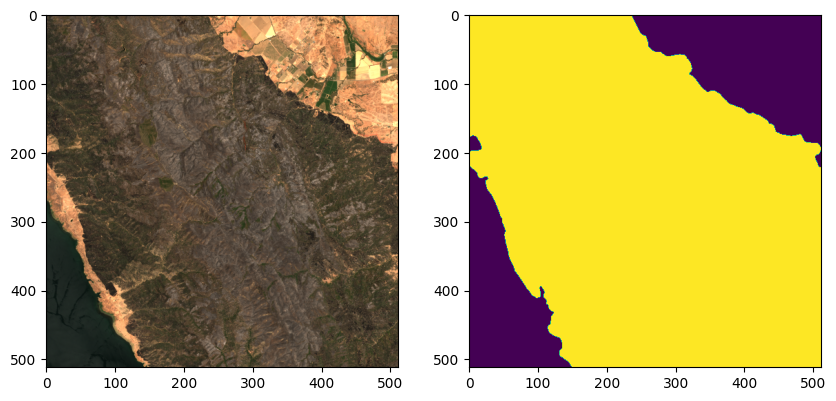

In [68]:
# Lets visualize the data
import matplotlib.pyplot as plt
import rioxarray as rxr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(rxr.open_rasterio(
    'data/HLSBurnScars/validation/subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4_merged.tif').sel(band=[3, 2, 1]).transpose("y", "x", "band").to_numpy() * 5)
ax[1].imshow(rxr.open_rasterio(
    'data/HLSBurnScars/validation/subsetted_512x512_HLS.S30.T10SEH.2018190.v1.4.mask.tif').to_numpy()[0])
plt.show()

In [65]:
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

# from https://github.com/NASA-IMPACT/hls-foundation-os/blob/main/configs/burn_scars.py
means=[
        0.033349706741586264,
        0.05701185520536176,
        0.05889748132001316,
        0.2323245113436119,
        0.1972854853760658,
        0.11944914225186566,
    ]
stds=[
        0.02269135568823774,
        0.026807560223070237,
        0.04004109844362779,
        0.07791732423672691,
        0.08708738838140137,
        0.07241979477437814,
    ]

# For 3 channel RGB models, you might want to use the ImageNet values: 
# mean = [0.485, 0.456, 0.406]
# stds = [0.229, 0.224, 0.225]

datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=4,
    num_workers=0,
    train_data_root=os.path.join(DATASET_PATH, 'training'),
    val_data_root=os.path.join(DATASET_PATH, 'validation'),
    test_data_root=os.path.join(DATASET_PATH, 'validation'), # We are reusing the validation set for testing 
    img_grep="*_merged.tif",
    label_grep="*.mask.tif",
    means=means,
    stds=stds,
    num_classes=2,

    # if transforms are defined with Albumentations, you can pass them here
    # train_transform=train_transform,
    # val_transform=val_transform,
    # test_transform=test_transform,

    # Bands of your dataset (in this case similar to the model bands)
    dataset_bands=hls_bands,
    # Input bands of your model
    output_bands=hls_bands,
    no_data_replace=0,
    no_label_replace=-1,
)
# we want to access some properties of the train dataset later on, so lets call setup here
# if not, we would not need to
datamodule.setup("fit")

# Lightning Trainers
At the highest level of abstraction, you can operate with task specific trainers. These encapsulate the model, loss, optimizer and any training hyperparameters.

They build on the model factory we introduced previously and are able to take any. To use a task with a model not supported by a currently existing model factory, simply create your own model factory!

Let's create a Trainer for Semantic Segmentation.

In [66]:
from terratorch.tasks import SemanticSegmentationTask

model_args = {
        "backbone":"resnet50", # see smp_encoders.keys()
        'model': 'Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus' 
        "bands": hls_bands,
        "in_channels": 6,
        "num_classes": 2,
        "pretrained": True,
}

task = SemanticSegmentationTask(
    model_args=model_args,
    model_factory="SMPModelFactory",
    loss="ce",
    lr=1e-4,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True,
    class_names=['Not burned', 'Burned'],
    class_weights=[0.1, 0.9]
)

In [67]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir='output', name='tutorial')

# You can also log directly to WandB
# from lightning.pytorch.loggers import WandbLogger
# wandb_logger = WandbLogger(log_model="all") 

trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=1, # train only one epoch for demo
    default_root_dir='output/tutorial',
    log_every_n_steps=1,
    check_val_every_n_epoch=1
)
_ = trainer.fit(model=task, datamodule=datamodule)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ SMPModelWrapper  │ 32.5 M │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 9.0 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130

Output()

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [40]:
res = trainer.test(model=task, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9042260646820068           │
│        test/Multiclass_F1_Score        │           0.9042260646820068           │
│     test/Multiclass_Jaccard_Index      │           0.6812360286712646           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.8251940011978149           │
│               test/loss                │          0.28467822074890137           │
│     test/multiclassaccuracy_Burned     │           0.906612753868103            │
│   test/multiclassaccuracy_Not burned   │           0.9039826393127441           │
│   test/multiclassjaccardindex_Burned   │          0.46701979637145996           │
│ test/multiclassjaccardindex_Not burned │           0.8954523205757141           │
└────────────────────────────────────────┴────────────────────────────────────────┘

In [49]:
# Analyze training in tensorboard
!tensorboard --logdir output/ --port 9010  # add --host $(hostname -f) for clusters

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.17.1 at http://Thornhill:9010/ (Press CTRL+C to quit)
^C


# CLI tool

You find an example for SMP models in `configs/burnscars_smp.yaml` that you can run with `terratorch fit -c configs/burnscars_smp.yaml`. 